In [1]:
!pip install joypy
!pip install cityscapesscripts

In [2]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Benchmarking

## Model Interface Requirements

To benchmark a new model, you need to wrap it in a class that follows this interface:

1.  **Input**: The `predict` method must accept a `PIL.Image.Image` in RGB mode.
2.  **Output**: The `predict` method must return a `numpy.ndarray` of shape `(Height, Width)` with integer type (e.g., `uint8` or `int64`).
    *   The values in the array should be the **trainIds** (0-18 for Cityscapes classes).
    *   Pixels to be ignored should be marked with `255` (or whatever your ignore index is, usually 255).

### Example Base Class Structure

```python
from abc import ABC, abstractmethod
import numpy as np
from PIL import Image

class BaseSegmentationModel(ABC):
    @abstractmethod
    def predict(self, image: Image.Image) -> np.ndarray:
        """
        Args:
            image (PIL.Image.Image): Input image (RGB).
        Returns:
            np.ndarray: Segmentation mask (H, W) with integer trainIds.
        """
        pass
```

In [3]:
# --- Step 1: Define General Model Interface & Setup SegFormer Example ---

from dataclasses import dataclass
from typing import Dict, List
from collections import defaultdict
from abc import ABC, abstractmethod

import numpy as np
from PIL import Image
import torch

# Cityscapes label definitions
from cityscapesscripts.helpers.labels import labels as CS_LABELS

# -----------------------------------------------------------------------------
# 1. Abstract Base Class for Segmentation Models
# -----------------------------------------------------------------------------
class BaseSegmentationModel(ABC):
    @abstractmethod
    def predict(self, image: Image.Image) -> np.ndarray:
        """
        Run inference on a single image.

        Args:
            image (PIL.Image.Image): Input image in RGB mode.

        Returns:
            np.ndarray: Predicted segmentation mask of shape (H, W).
                        Values should be integer trainIds (0-18).
        """
        pass

In [4]:
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

# -----------------------------------------------------------------------------
# 2. Concrete Implementation: SegFormer Wrapper
# -----------------------------------------------------------------------------
class SegFormerWrapper(BaseSegmentationModel):
    def __init__(self, model_name: str = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Loading {model_name} on {self.device}...")

        self.processor = SegformerImageProcessor.from_pretrained(model_name)
        self.model = SegformerForSemanticSegmentation.from_pretrained(model_name).to(self.device)
        self.model.eval()

    def predict(self, image: Image.Image) -> np.ndarray:
        # Ensure RGB
        if image.mode != "RGB":
            image = image.convert("RGB")

        inputs = self.processor(images=image, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits

            # Upsample logits to original image size (H, W)
            # image.size is (W, H)
            upsampled_logits = torch.nn.functional.interpolate(
                logits,
                size=image.size[::-1],
                mode="bilinear",
                align_corners=False,
            )

        # argmax gives the class index (trainId for this model)
        pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy().astype(np.uint8)
        return pred_seg

# Instantiate the model we want to test
# To test a different model, implement a new wrapper and instantiate it here.
current_model = SegFormerWrapper()

Loading nvidia/segformer-b1-finetuned-cityscapes-1024-1024 on cuda...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.8M [00:00<?, ?B/s]

In [5]:
@dataclass
class LabelSpec:
    name: str            # "road"
    group: str           # "flat"
    id: int              # Cityscapes labelId
    train_id: int        # Cityscapes trainId (0-18, 255 = ignore)
    ignore_in_eval: bool # True for '+' labels / void classes

def build_cityscapes_label_specs() -> Dict[str, LabelSpec]:
    specs: Dict[str, LabelSpec] = {}
    for lab in CS_LABELS:
        specs[lab.name] = LabelSpec(
            name=lab.name,
            group=lab.category,
            id=lab.id,
            train_id=lab.trainId,
            ignore_in_eval=lab.ignoreInEval,
        )
    return specs

CITYSCAPES_LABEL_SPECS: Dict[str, LabelSpec] = build_cityscapes_label_specs()

# Map raw labelId -> trainId (255 for ignore)
CITYSCAPES_ID2TRAINID: Dict[int, int] = {}
for spec in CITYSCAPES_LABEL_SPECS.values():
    tid = spec.train_id
    if tid < 0:
        tid = 255
    CITYSCAPES_ID2TRAINID[spec.id] = tid

# Official 19 evaluation classes
CITYSCAPES_EVAL_TRAIN_IDS: List[int] = sorted(
    {
        spec.train_id
        for spec in CITYSCAPES_LABEL_SPECS.values()
        if spec.train_id >= 0 and not spec.ignore_in_eval
    }
)

CITYSCAPES_TRAINID2NAME: Dict[int, str] = {
    spec.train_id: spec.name
    for spec in CITYSCAPES_LABEL_SPECS.values()
    if spec.train_id in CITYSCAPES_EVAL_TRAIN_IDS
}

CITYSCAPES_NUM_CLASSES: int = 256
CITYSCAPES_IGNORE_INDEX: int = 255

In [6]:
# If your dataset is on Drive, mount and point ROOT there
from google.colab import drive
drive.mount("/content/drive")

model.safetensors:   0%|          | 0.00/54.8M [00:00<?, ?B/s]

Mounted at /content/drive


In [7]:
from pathlib import Path
# CITYSCAPES_ROOT = Path("/content/drive/MyDrive/cityscapes")
CITYSCAPES_ROOT = Path("/content/drive/MyDrive/UCLA/Datasets/cityscapes")

In [8]:

# --- Step 2: Load Cityscapes val split paths in Colab ---

def list_cityscapes_split(root: Path, split: str = "val"):
    img_dir = root / "leftImg8bit_trainvaltest" / "leftImg8bit" / split
    gt_dir  = root / "gtFine_trainvaltest" / "gtFine" / split

    image_paths = sorted(img_dir.rglob("*_leftImg8bit.png"))
    print(f"Found {len(image_paths)} images in split='{split}'")
    return image_paths, gt_dir

val_image_paths, val_gt_dir = list_cityscapes_split(CITYSCAPES_ROOT, split="val")


Found 500 images in split='val'


In [9]:
# --- Step 3: Build a parseable representation (DataFrame) for val ---

import pandas as pd

def make_cityscapes_dataframe(root: Path, split: str = "val") -> pd.DataFrame:
    img_dir = root / "leftImg8bit_trainvaltest" / "leftImg8bit" / split
    gt_dir  = root / "gtFine_trainvaltest" / "gtFine" / split

    records = []
    for img_path in sorted(img_dir.rglob("*_leftImg8bit.png")):
        city = img_path.parent.name
        stem = img_path.name.replace("_leftImg8bit.png", "")

        label_ids = gt_dir / city / f"{stem}_gtFine_labelIds.png"
        instance_ids = gt_dir / city / f"{stem}_gtFine_instanceIds.png"
        color_png = gt_dir / city / f"{stem}_gtFine_color.png"
        polygons_json = gt_dir / city / f"{stem}_gtFine_polygons.json"

        records.append(
            {
                "city": city,
                "image_id": stem,
                "image_path": str(img_path),
                "labelIds_path": str(label_ids),
                "instanceIds_path": str(instance_ids),
                "color_path": str(color_png),
                "polygons_path": str(polygons_json),
            }
        )

    df = pd.DataFrame.from_records(records)
    return df


val_df = make_cityscapes_dataframe(CITYSCAPES_ROOT, split="val")
print("Total val samples:", len(val_df))
display(val_df.head())


Total val samples: 500


,city,image_id,image_path,labelIds_path,instanceIds_path,color_path,polygons_path
0,frankfurt,frankfurt_000000_000294,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
1,frankfurt,frankfurt_000000_000576,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
2,frankfurt,frankfurt_000000_001016,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
3,frankfurt,frankfurt_000000_001236,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
4,frankfurt,frankfurt_000000_001751,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...


In [10]:
# -----------------------------------------------------------------------------
# 3.5 Finetuning Setup: OHEM Loss & Oversampling
# -----------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerImageProcessor
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

# Helper for label conversion (needed for Dataset)
lut = np.full(256, CITYSCAPES_IGNORE_INDEX, dtype=np.uint8)
for raw, tid in CITYSCAPES_ID2TRAINID.items():
    lut[raw] = np.uint8(tid)

def labelIds_to_trainIds_fast(label_ids: np.ndarray) -> np.ndarray:
    return lut[label_ids]

# 1. OHEM Loss
class OhemCrossEntropyLoss(nn.Module):
    def __init__(self, ignore_index=255, thresh=0.7, min_kept=100000):
        super(OhemCrossEntropyLoss, self).__init__()
        self.ignore_index = ignore_index
        # thresh: probability threshold. If prob < thresh, it's a "hard" example.
        self.thresh = -torch.log(torch.tensor(thresh)).cuda()
        self.min_kept = min_kept

    def forward(self, pred, target):
        # pred: [batch, classes, h, w], target: [batch, h, w]
        n, c, h, w = pred.size()
        target = target.view(-1)
        pred = pred.view(n, c, -1)

        # Get probabilities
        prob = F.softmax(pred, dim=1)
        prob = prob.transpose(0, 1).reshape(c, -1)

        # Get the probability of the *correct* class for each pixel
        target_valid = target.clone()
        target_valid[target_valid == self.ignore_index] = 0 # Avoid indexing error
        prob = prob.gather(0, target_valid.view(1, -1)).view(-1)

        # Mask out ignore_index
        valid_mask = target != self.ignore_index
        prob = prob[valid_mask]
        target = target[valid_mask]

        # OHEM Logic: Keep pixels where prob < thresh (hard examples)
        # But always keep at least 'min_kept' pixels to stabilize training
        keep_mask = prob < self.thresh
        if keep_mask.sum() < self.min_kept:
            _, sorted_indices = prob.sort()
            keep_mask[sorted_indices[:self.min_kept]] = True

        # Compute standard CE only on the kept pixels
        loss = F.cross_entropy(pred.transpose(1, 2).reshape(-1, c), target_valid.view(-1), reduction='none')
        loss = loss[valid_mask][keep_mask]

        return loss.mean()

# 2. Oversampling Dataset
class CityscapesOversamplingDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor
        self.records = []

        # Identify pole and fence trainIds
        # Ensure CITYSCAPES_LABEL_SPECS is available (defined in previous cells)
        pole_id = CITYSCAPES_LABEL_SPECS['pole'].train_id
        fence_id = CITYSCAPES_LABEL_SPECS['fence'].train_id

        print("Scanning dataset for oversampling (poles/fences)...")
        for _, row in tqdm(df.iterrows(), total=len(df)):
            # Load GT to check for poles/fences
            gt = np.array(Image.open(row['labelIds_path']), dtype=np.uint8)
            gt_train = labelIds_to_trainIds_fast(gt)

            pole_count = (gt_train == pole_id).sum()
            fence_count = (gt_train == fence_id).sum()

            count = 1
            if pole_count > 50 or fence_count > 50:
                count = 3 # Add 3 times if it has significant pole/fence pixels

            for _ in range(count):
                self.records.append(row)

        print(f"Original size: {len(df)}, Oversampled size: {len(self.records)}")

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        row = self.records[idx]
        image = Image.open(row['image_path']).convert("RGB")

        gt = np.array(Image.open(row['labelIds_path']), dtype=np.uint8)
        gt_train = labelIds_to_trainIds_fast(gt)
        label = Image.fromarray(gt_train)

        # Processor handles resizing and normalization
        inputs = self.processor(images=image, segmentation_maps=label, return_tensors="pt")

        return {
            "pixel_values": inputs.pixel_values.squeeze(0),
            "labels": inputs.labels.squeeze(0)
        }

In [12]:
# --- Step 3.6: Run Finetuning ---

# 1. Prepare Data
# Ensure we have the train split
# Note: If running locally, ensure CITYSCAPES_ROOT points to the correct location
# We use 'try-except' or check if split exists to avoid errors if data is missing
try:
    train_df = make_cityscapes_dataframe(CITYSCAPES_ROOT, split="train")
    print("Total train samples (before oversampling):", len(train_df))
except Exception as e:
    print(f"Could not load train split: {e}")
    train_df = pd.DataFrame() # Empty if failed

# Initialize Processor (same as used in SegFormerWrapper)
model_name = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024"
processor = SegformerImageProcessor.from_pretrained(model_name)

# 2. Training Loop
def train_model(model_name, train_loader, num_epochs=1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Training on {device}...")

    model = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device)
    model.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
    criterion = OhemCrossEntropyLoss(ignore_index=CITYSCAPES_IGNORE_INDEX)

    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits

            # Resize logits to match labels
            upsampled_logits = F.interpolate(
                logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
            )

            loss = criterion(upsampled_logits, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        print(f"Epoch {epoch+1} Average Loss: {epoch_loss/len(train_loader)}")

    return model

# Run Training (Uncomment to run)
if not train_df.empty:
    # Create Dataset and DataLoader
    train_dataset = CityscapesOversamplingDataset(train_df, processor)
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0) # Adjust batch_size as needed

    # Train
    finetuned_model = train_model(model_name, train_loader, num_epochs=1)

    # Save
    finetuned_model.save_pretrained("segformer_ohem_finetuned")
    processor.save_pretrained("segformer_ohem_finetuned")
else:
    print("Skipping training setup as train data is missing.")

Total train samples (before oversampling): 2975
Scanning dataset for oversampling (poles/fences)...


/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


  0%|          | 0/2975 [00:00<?, ?it/s]

Original size: 2975, Oversampled size: 8883
Training on cuda...


Epoch 1/1:   0%|          | 0/4442 [00:00<?, ?it/s]

Epoch 1 Average Loss: 1.117932594879851


In [14]:
# --- Step 3.7: Update Wrapper to use Finetuned Model ---

class SegFormerWrapperOHEM(BaseSegmentationModel):
    def __init__(self, model_path_or_name: str = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024", model_instance=None):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        if model_instance:
            print("Loading provided model instance...")
            self.model = model_instance.to(self.device)
            # Assuming processor is same as base or loaded separately if needed
            # If model_path_or_name is a path to saved model, processor should be loaded from there too
            try:
                self.processor = SegformerImageProcessor.from_pretrained(model_path_or_name)
            except:
                # Fallback to default if local path doesn't have processor config or using instance
                self.processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
        else:
            print(f"Loading {model_path_or_name} on {self.device}...")
            self.processor = SegformerImageProcessor.from_pretrained(model_path_or_name)
            self.model = SegformerForSemanticSegmentation.from_pretrained(model_path_or_name).to(self.device)

        self.model.eval()

    def predict(self, image: Image.Image) -> np.ndarray:
        # Ensure RGB
        if image.mode != "RGB":
            image = image.convert("RGB")

        inputs = self.processor(images=image, return_tensors="pt").to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits

            # Upsample logits to original image size (H, W)
            # image.size is (W, H)
            upsampled_logits = F.interpolate(
                logits,
                size=image.size[::-1],
                mode="bilinear",
                align_corners=False,
            )

        # argmax gives the class index (trainId for this model)
        pred_seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy().astype(np.uint8)
        return pred_seg

# Instantiate the model we want to test
# If you ran training, you can pass the finetuned model:
current_model = SegFormerWrapperOHEM(model_instance=finetuned_model)
# Or load from saved path:
# current_model = SegFormerWrapper(model_path_or_name="segformer_ohem_finetuned")

# Default (Pretrained)
# current_model = SegFormerOHEMWrapper()


Loading provided model instance...


/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


In [15]:
# --- Step 4: Run Inference using the General Model Interface ---

from tqdm.auto import tqdm
import numpy as np

# Define where to save predictions for the current model
# We use the class name to distinguish different models
model_dir_name = current_model.__class__.__name__ + "_preds"
PRED_ROOT = CITYSCAPES_ROOT / model_dir_name / "val"
PRED_ROOT.mkdir(parents=True, exist_ok=True)


def run_inference_over_df(
    df: pd.DataFrame,
    model: BaseSegmentationModel,
    pred_root: Path,
    overwrite: bool = False,
) -> pd.DataFrame:
    """
    Generic inference loop using BaseSegmentationModel.

    Args:
        df: DataFrame containing image paths.
        model: Instance of BaseSegmentationModel.
        pred_root: Directory to save .npy predictions.
        overwrite: If True, re-run inference even if file exists.
    """
    df = df.copy()
    pred_paths = []

    print(f"Running inference with {model.__class__.__name__}...")
    print(f"Saving results to: {pred_root}")

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = Path(row["image_path"])
        image_id = row["image_id"]

        # We'll save as {image_id}_trainIds.npy
        out_path = pred_root / f"{image_id}_trainIds.npy"

        if out_path.exists() and not overwrite:
            pred_paths.append(str(out_path))
            continue

        # Load Image
        img = Image.open(img_path).convert("RGB")

        # Predict using the abstract interface
        pred_trainids = model.predict(img)

        # Save
        np.save(out_path, pred_trainids)
        pred_paths.append(str(out_path))

    df["pred_trainIds_path"] = pred_paths
    return df


# Run inference with the instantiated 'current_model'
val_df_pred = run_inference_over_df(
    val_df,
    model=current_model,
    pred_root=PRED_ROOT,
    overwrite=False,
)

display(val_df_pred.head())

Running inference with SegFormerWrapperOHEM...
Saving results to: /content/drive/MyDrive/UCLA/Datasets/cityscapes/SegFormerWrapperOHEM_preds/val


  0%|          | 0/500 [00:00<?, ?it/s]

,city,image_id,image_path,labelIds_path,instanceIds_path,color_path,polygons_path,pred_trainIds_path
0,frankfurt,frankfurt_000000_000294,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
1,frankfurt,frankfurt_000000_000576,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
2,frankfurt,frankfurt_000000_001016,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
3,frankfurt,frankfurt_000000_001236,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...
4,frankfurt,frankfurt_000000_001751,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...,/content/drive/MyDrive/UCLA/Datasets/cityscape...


In [16]:
def iou_from_confusion(cm: np.ndarray) -> np.ndarray:
    intersection = np.diag(cm)
    union = cm.sum(axis=1) + cm.sum(axis=0) - intersection
    return intersection / np.maximum(union, 1)

def evaluate_and_collect(df):
    global_cm = np.zeros((CITYSCAPES_NUM_CLASSES, CITYSCAPES_NUM_CLASSES), dtype=np.int64)
    rows = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        # load GT + pred
        gt = np.array(Image.open(row.labelIds_path), dtype=np.uint8)
        gt = labelIds_to_trainIds_fast(gt)
        pred = np.load(row.pred_trainIds_path).astype(np.uint8)
        pred = np.clip(pred, 0, CITYSCAPES_NUM_CLASSES - 1)

        # mask + flatten
        mask = gt != CITYSCAPES_IGNORE_INDEX
        gt_f = gt[mask].astype(np.int64) # Cast gt_f to int64
        pred_f = pred[mask].astype(np.int64) # Cast pred_f to int64

        idx = np.int64(CITYSCAPES_NUM_CLASSES) * gt_f + pred_f

        # per-image CM
        cm = np.bincount(idx, minlength=CITYSCAPES_NUM_CLASSES**2).reshape(
            CITYSCAPES_NUM_CLASSES, CITYSCAPES_NUM_CLASSES
        )

        # add to global CM
        global_cm += cm

        # per-image IoU
        inter = np.diag(cm)
        union = cm.sum(0) + cm.sum(1) - inter
        iou = np.where(union > 0, inter/union, np.nan)

        entry = {
            "image_id": row["image_id"],
            "city": row["city"],
        }
        for tid in CITYSCAPES_EVAL_TRAIN_IDS:
            entry[CITYSCAPES_TRAINID2NAME[tid]] = iou[tid]

        rows.append(entry)

    return global_cm, pd.DataFrame(rows)

In [17]:
lut = np.full(256, CITYSCAPES_IGNORE_INDEX, dtype=np.uint8)
for raw, tid in CITYSCAPES_ID2TRAINID.items():
    lut[raw] = np.uint8(tid)

def labelIds_to_trainIds_fast(label_ids: np.ndarray) -> np.ndarray:
    return lut[label_ids]


# ===============================================
# Fast confusion matrix calculation
# ===============================================
def confusion_matrix_from_df_fast(
    df: pd.DataFrame,
    num_classes: int = CITYSCAPES_NUM_CLASSES,
    ignore_index: int = CITYSCAPES_IGNORE_INDEX,
) -> np.ndarray:

    cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    # ---- Preload all GTs & predictions to avoid slow disk I/O ----
    gt_list = []
    pred_list = []

    for row in tqdm(df.itertuples(), total=len(df), desc="Loading GT + predictions"):
        gt = np.array(Image.open(row.labelIds_path), dtype=np.uint8)
        gt_list.append(labelIds_to_trainIds_fast(gt))

        pred = np.load(row.pred_trainIds_path).astype(np.uint8)
        pred_list.append(np.clip(pred, 0, num_classes - 1))

    # ---- Compute confusion matrix in vectorized form ----
    for gt_train, pred_train in tqdm(zip(gt_list, pred_list), total=len(gt_list),
                                     desc="Computing confusion matrix"):

        mask = gt_train != ignore_index

        gt_flat = gt_train[mask].astype(np.int64)
        pred_flat = pred_train[mask].astype(np.int64)

        idx = num_classes * gt_flat + pred_flat

        cm += np.bincount(
            idx,
            minlength=num_classes * num_classes,
        ).reshape(num_classes, num_classes)

    return cm

The next two blocks are for speed improvements

In [18]:
!rsync -ah --info=progress2 /content/drive/MyDrive/cityscapes/ /content/cityscapes_local/

rsync: [sender] change_dir "/content/drive/MyDrive/cityscapes" failed: No such file or directory (2)
              0 100%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/0)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1338) [sender=3.2.7]


In [19]:
val_df_pred["labelIds_path"] = val_df_pred["labelIds_path"].str.replace(
    "/content/drive/MyDrive/cityscapes/",
    "/content/cityscapes_local/"
)

val_df_pred["pred_trainIds_path"] = val_df_pred["pred_trainIds_path"].str.replace(
    "/content/drive/MyDrive/cityscapes/",
    "/content/cityscapes_local/"
)

In [20]:
global_cm, per_image_iou_df = evaluate_and_collect(val_df_pred)
ious = iou_from_confusion(global_cm)

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-2253135274.py:35: RuntimeWarning: invalid value encountered in divide
  iou = np.where(union > 0, inter/union, np.nan)


In [21]:
per_image_iou_df

,image_id,city,road,sidewalk,building,wall,fence,pole,traffic light,traffic sign,...,terrain,sky,person,rider,car,truck,bus,train,motorcycle,bicycle
0,frankfurt_000000_000294,frankfurt,0.981420,0.916552,0.969533,NaN,0.000000,0.589134,0.000000,0.570522,...,NaN,0.949207,0.789292,NaN,0.939943,NaN,NaN,NaN,NaN,NaN
1,frankfurt_000000_000576,frankfurt,0.990565,0.948954,0.961861,NaN,0.742372,0.177404,NaN,0.688757,...,0.000000,0.965320,0.000000,0.579418,0.964803,NaN,NaN,NaN,NaN,0.448316
2,frankfurt_000000_001016,frankfurt,0.958599,0.516596,0.989464,NaN,NaN,0.574652,0.000000,0.908992,...,NaN,NaN,0.646545,0.685571,0.944604,NaN,NaN,NaN,0.0,0.652217
3,frankfurt_000000_001236,frankfurt,0.983167,0.578859,0.647378,NaN,0.614983,0.396202,0.513707,0.677704,...,0.000000,0.951554,0.582189,0.063611,0.956433,0.000000,NaN,NaN,NaN,0.390403
4,frankfurt_000000_001751,frankfurt,0.989441,0.730631,0.917003,NaN,NaN,0.191574,0.500000,0.549980,...,0.000000,0.977530,0.088799,0.332078,0.961403,0.326544,NaN,NaN,NaN,0.451042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,munster_000169_000019,munster,0.994214,0.871342,0.894688,0.00000,0.000000,0.523165,0.739942,0.844442,...,0.000000,0.973393,0.269257,0.380801,0.856781,0.000000,NaN,NaN,NaN,0.415020
496,munster_000170_000019,munster,0.993100,0.000000,0.024672,NaN,NaN,0.442982,0.428647,0.880178,...,0.000000,0.944079,0.000000,0.391026,0.954167,NaN,NaN,NaN,NaN,0.177730
497,munster_000171_000019,munster,0.994298,0.926818,0.580232,0.00000,0.431714,0.541991,NaN,0.000000,...,0.792665,0.967181,0.025035,0.428302,0.961838,0.000000,0.76766,NaN,NaN,0.457436
498,munster_000172_000019,munster,0.985317,0.403093,0.920629,0.00000,NaN,0.458712,0.000000,0.740422,...,0.789937,0.981051,0.186186,NaN,0.969703,NaN,NaN,NaN,NaN,0.225806


In [22]:
print("Per-class IoU (Cityscapes 19 eval classes):")
for tid in CITYSCAPES_EVAL_TRAIN_IDS:
    name = CITYSCAPES_TRAINID2NAME[tid]
    print(f"{tid:2d} {name:>12s}: {ious[tid] * 100:5.2f}%")

miou = np.mean([ious[tid] for tid in CITYSCAPES_EVAL_TRAIN_IDS])
print(f"\nMean IoU over {len(CITYSCAPES_EVAL_TRAIN_IDS)} classes: {miou * 100:5.2f}%")

Per-class IoU (Cityscapes 19 eval classes):
 0         road: 98.06%
 1     sidewalk: 84.00%
 2     building: 91.01%
 3         wall: 54.12%
 4        fence: 55.42%
 5         pole: 53.41%
 6 traffic light: 64.20%
 7 traffic sign: 74.12%
 8   vegetation: 91.57%
 9      terrain: 62.78%
10          sky: 94.23%
11       person: 76.01%
12        rider: 51.16%
13          car: 93.60%
14        truck: 76.80%
15          bus: 79.79%
16        train: 65.99%
17   motorcycle: 56.83%
18      bicycle: 72.53%

Mean IoU over 19 classes: 73.45%


In [23]:
import joypy
import matplotlib.pyplot as plt
import numpy as np

# Identify class columns
class_cols = [c for c in per_image_iou_df.columns if c not in ['image_id', 'city']]

# Sort by class difficulty (median IoU)
median_iou = per_image_iou_df[class_cols].median().sort_values()
sorted_classes = median_iou.index.tolist()

# Build clean data: each class has its own filtered 1D array
clean_data = {}
for cls in sorted_classes:
    col = per_image_iou_df[cls]
    # convert strings or invalid entries to NaN
    col = pd.to_numeric(col, errors='coerce')
    # remove NaNs (meaning class absent)
    col = col.dropna()
    clean_data[cls] = col.values

In [24]:
class_cols = [c for c in per_image_iou_df.columns if c not in ['image_id', 'city']]

long_df = (
    per_image_iou_df[class_cols]
    .melt(var_name='category', value_name='IoU')
    .dropna()
)

# drop NaNs (class not present in image) )
plot_df = long_df[long_df["IoU"] > 0]


<Figure size 1000x1200 with 0 Axes>

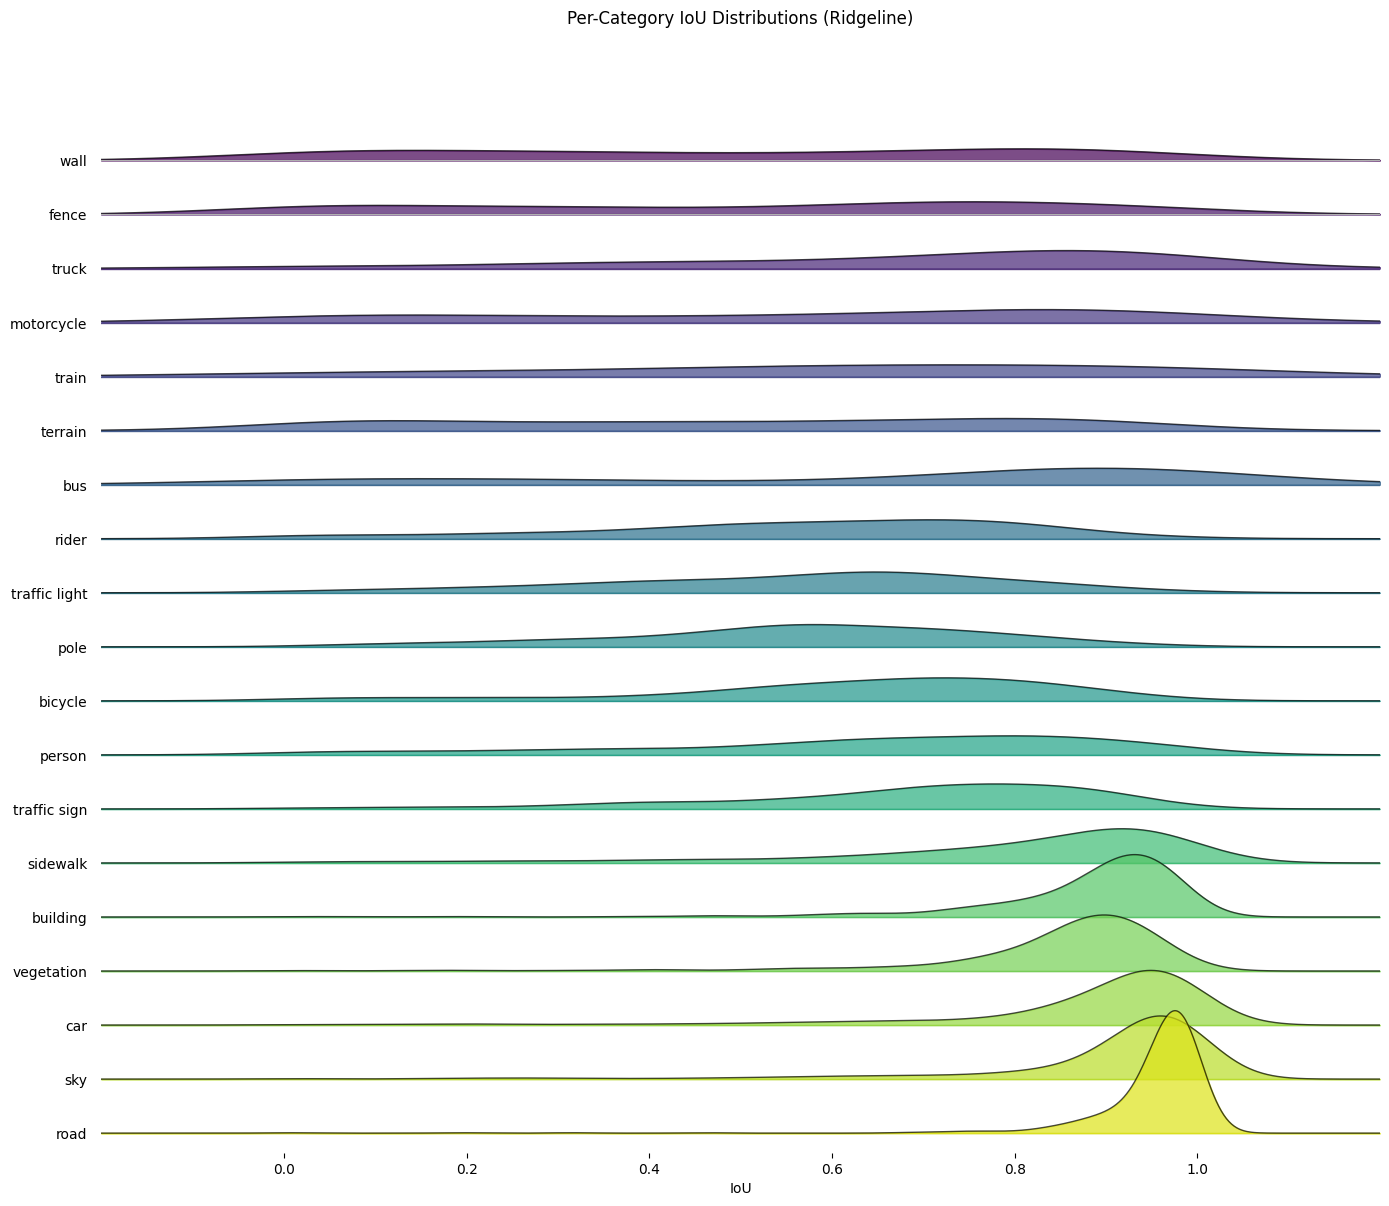

In [25]:
import joypy
import matplotlib.pyplot as plt

# Pivot long_df back to wide form for joypy
pivot_df = plot_df.pivot(columns='category', values='IoU')
norm_df = pivot_df.apply(lambda s: (s - s.min()) / (s.max() - s.min()))

plt.figure(figsize=(10, 12))
joypy.joyplot(
    data=norm_df,
    column=sorted_classes,
    labels=sorted_classes,
    range_style='own',
    grid="y",
    linewidth=1,
    legend=False,
    figsize=(14, 12),
    title="Distribution of Per-Image IoU by Class (NaNs removed correctly)",
    colormap=plt.cm.viridis,
    alpha=0.7,
    overlap=1.4,
)
# joypy.joyplot(
#     pivot_df,
#     column=sorted_classes,
#     labels=sorted_classes,
#     kind="kde",
#     range_style="own",
#     bw_method=0.3,     # ← try values 0.1–0.3 for smoothness
#     linewidth=1,
#     colormap=plt.cm.viridis,
#     overlap=1.4,
# )
plt.title("Per-Category IoU Distributions (Ridgeline)")
plt.xlabel("IoU")
plt.show()


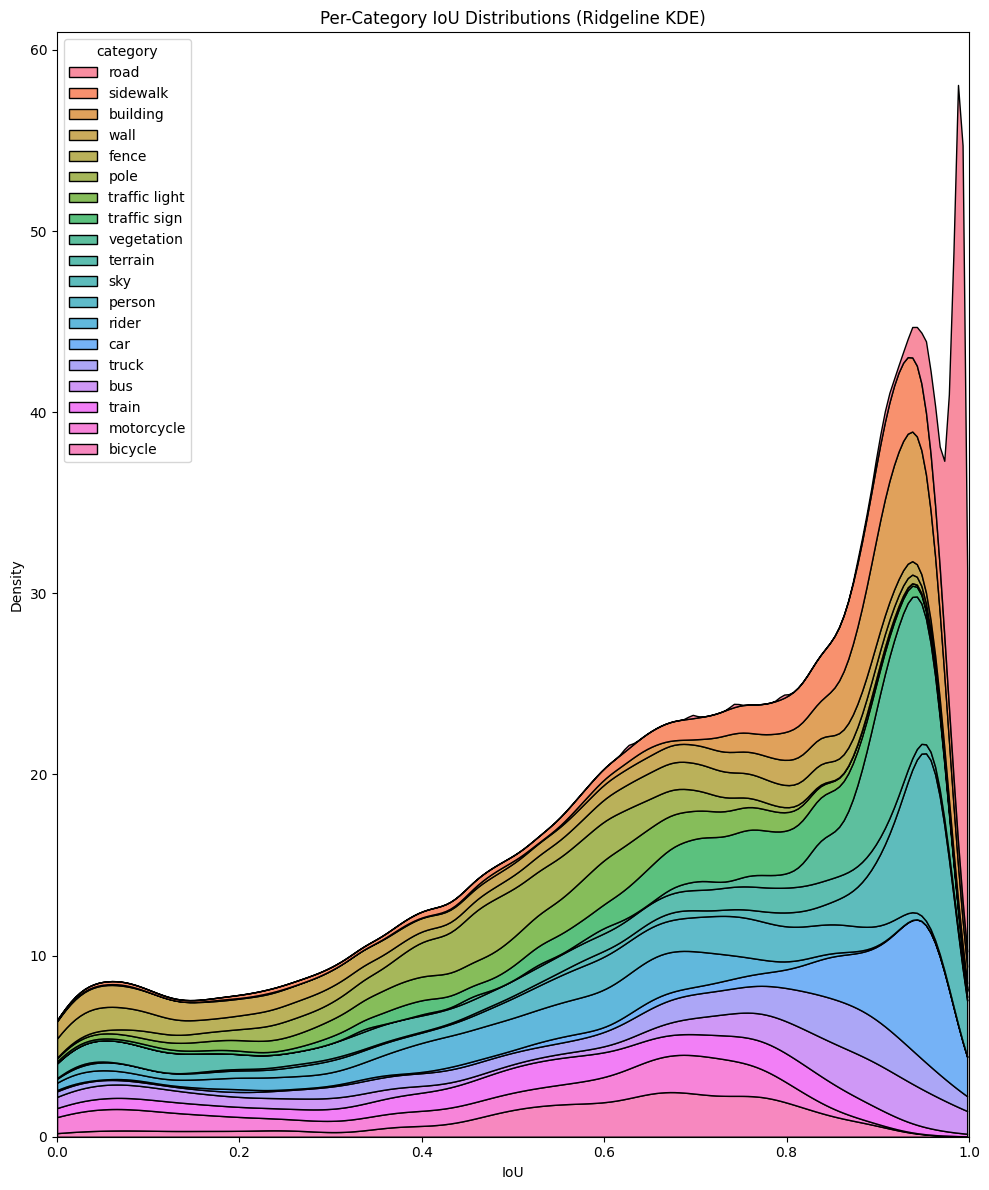

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 12))

sns.kdeplot(
    data=plot_df,
    x="IoU",
    hue="category",
    fill=True,
    alpha=0.8,
    linewidth=1,
    multiple="stack",
    common_norm=False,
    bw_adjust=0.5,
    cut=0
)

plt.xlim(0, 1)
plt.title("Per-Category IoU Distributions (Ridgeline KDE)")
plt.xlabel("IoU")
plt.tight_layout()
plt.show()


# Save Results for Comparative Analysis

In [27]:
# Construct a filename based on the model class name
model_name = current_model.__class__.__name__
csv_filename = f"{model_name}_per_image_iou.csv"
save_path = CITYSCAPES_ROOT / "benchmark_results" / csv_filename

# Ensure directory exists
save_path.parent.mkdir(parents=True, exist_ok=True)

# Save
per_image_iou_df.to_csv(save_path, index=False)
print(f"Saved per-image IoU stats to: {save_path}")

Saved per-image IoU stats to: /content/drive/MyDrive/UCLA/Datasets/cityscapes/benchmark_results/SegFormerWrapperOHEM_per_image_iou.csv
